# Using CNN to Predict Myocardial Infarction

#### Import required libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential #type: ignore
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization #type: ignore
from tensorflow.keras.callbacks import EarlyStopping #type: ignore

### 1. Image Preprocessing

#### Load the data

In [2]:
#defines the class labels
class_names = {
    'ECG Images of Myocardial Infarction Patients': 0,
    'ECG Images of Patient that have abnormal heartbeat': 1,
    'ECG Images of Patient that have History of MI': 2,
    'Normal Person ECG Images': 3
}
#function to load images and corresponding labels
def load_images(file_path):
    images = []
    labels = []
    
    #iterates through each class folder
    for class_name, label in class_names.items():
        class_path = os.path.join(file_path, class_name)
        print(f"Loading {len(os.listdir(class_path))} images for class '{class_name}'")  # Debug line
        #iterates through each image file in the folder
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name) #construct full path to image
            img = Image.open(img_path) #opens image file
            images.append(img) #adds to the image list
            labels.append(label) #adds corresponding labels

    print(f"Total images loaded: {len(images)}, Total labels loaded: {len(labels)}")  # Debug line
    #converts lists to numpy arrays and return
    return np.array(images), np.array(labels)

#loads the training and testing datasets
train_images, train_labels = load_images('ECG_Image_dataset_augmented/train')
test_images, test_labels = load_images('ECG_Image_dataset_augmented/test')

Loading 478 images for class 'ECG Images of Myocardial Infarction Patients'
Loading 466 images for class 'ECG Images of Patient that have abnormal heartbeat'
Loading 344 images for class 'ECG Images of Patient that have History of MI'
Loading 568 images for class 'Normal Person ECG Images'
Total images loaded: 1856, Total labels loaded: 1856
Loading 224 images for class 'ECG Images of Myocardial Infarction Patients'
Loading 224 images for class 'ECG Images of Patient that have abnormal heartbeat'
Loading 224 images for class 'ECG Images of Patient that have History of MI'
Loading 224 images for class 'Normal Person ECG Images'
Total images loaded: 896, Total labels loaded: 896


#### Reshaping the Images

In [3]:
#reshapes the images for CNN input (add channel dimension for grayscale)
train_images = train_images.reshape(-1, 128, 128, 1)
test_images = test_images.reshape(-1, 128, 128, 1)
train_images.shape

(1856, 128, 128, 1)

#### One-hot Encoding the Labels

In [4]:
#one-hot encoded the labels
num_classes = 4
train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=num_classes)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=num_classes)

### 2. Build the CNN Model

In [5]:
#builds and compiles a CNN model
def create_model():
    model = Sequential() #initializes a sequential model
    #input layer
    model.add(Input(shape=(128,128,1)))
    #first convolutional block
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    #second convolutional block
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    #third convolutional block
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    #flattening the feature maps
    model.add(Flatten())
    #fully connected layers
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))
    #output layer
    model.add(Dense(num_classes, activation='softmax'))
    #compiling the model using Adam optimizer
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    #returns the model
    return model
#creates the CNN model
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 64)       2

### 3. Train the Model

In [6]:
#early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
#learning rate scheduler callback
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)

In [ ]:
#trains the model with the epochs and callbacks
history = model.fit(train_images, train_labels, epochs=100, batch_size=32, 
                    validation_data=(test_images, test_labels), 
                    callbacks=[early_stopping, lr_scheduler])

Epoch 1/100
58/58 [==============================] - 28s 449ms/step - loss: 2.0746 - accuracy: 0.3184 - val_loss: 1.5301 - val_accuracy: 0.2578 - lr: 1.0000e-04
Epoch 2/100
58/58 [==============================] - 25s 432ms/step - loss: 1.4025 - accuracy: 0.3238 - val_loss: 1.3791 - val_accuracy: 0.2924 - lr: 1.0000e-04
Epoch 3/100
58/58 [==============================] - 25s 427ms/step - loss: 1.3066 - accuracy: 0.3895 - val_loss: 1.2778 - val_accuracy: 0.3527 - lr: 1.0000e-04
Epoch 4/100
58/58 [==============================] - 34s 587ms/step - loss: 1.2519 - accuracy: 0.4100 - val_loss: 1.4022 - val_accuracy: 0.3170 - lr: 1.0000e-04
Epoch 5/100
58/58 [==============================] - 55s 937ms/step - loss: 1.1793 - accuracy: 0.4768 - val_loss: 1.2754 - val_accuracy: 0.4074 - lr: 1.0000e-04
Epoch 6/100
58/58 [==============================] - 49s 839ms/step - loss: 1.1573 - accuracy: 0.4925 - val_loss: 1.2094 - val_accuracy: 0.4141 - lr: 1.0000e-04
Epoch 7/100
58/58 [===============

### 4. Evaluate the Model

In [8]:
#evaluates the model on the test dataset and prints accuracy
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy: {test_acc * 100}')

28/28 [==============================] - 3s 115ms/step - loss: 0.4402 - accuracy: 0.8449
Test accuracy: 84.48660969734192


### 5. Vizualize Training History

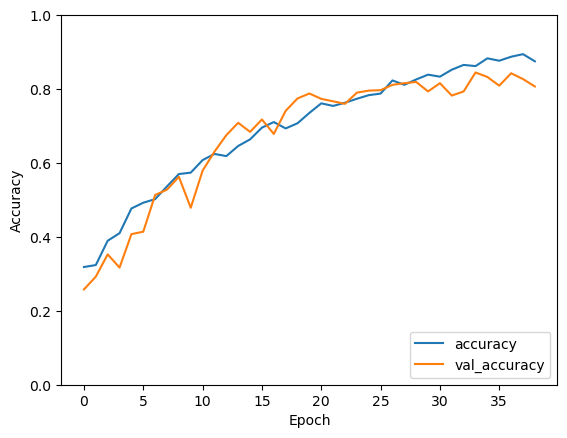

In [9]:
#plots the training and validation accuracies
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

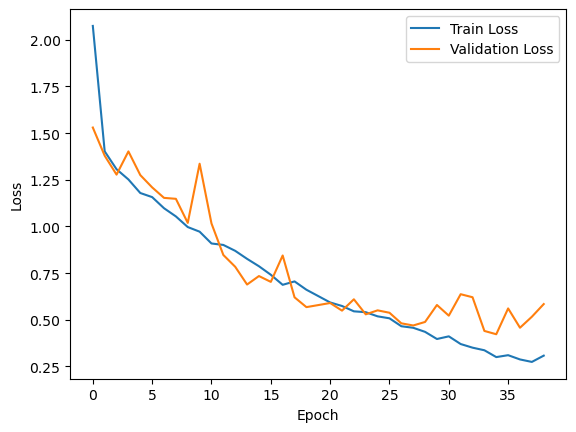

In [10]:
#plots the training and validation losses
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

### 6. Make Predictions

In [11]:
#generates predictions for the test images
predictions = model.predict(test_images)
#converts predicted probabilites to class labels
predicted_classes = np.argmax(predictions, axis=1)
#converts one-hot encoded labels to class labels
actual_classes = np.argmax(test_labels, axis=1)

28/28 [==============================] - 4s 117ms/step


### 7. Generate Confusion Matrix

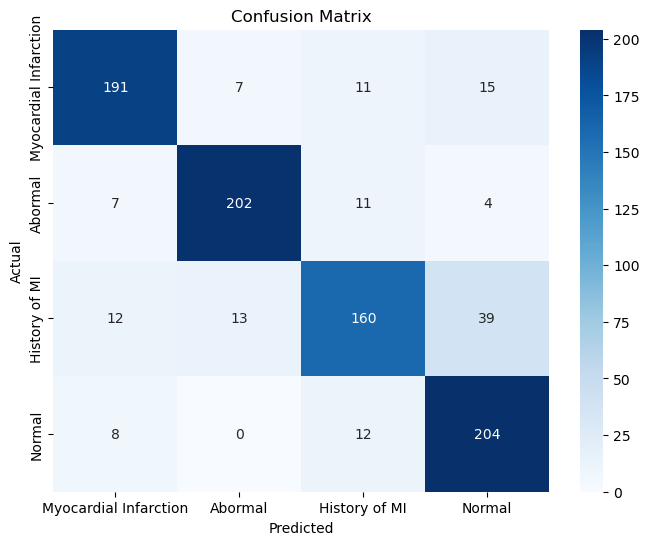

In [12]:
#compute the confusion matrix
conf_matrix = confusion_matrix(actual_classes, predicted_classes)

#plots the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Myocardial Infarction', 'Abormal', 'History of MI', 'Normal'],
            yticklabels=['Myocardial Infarction', 'Abormal', 'History of MI', 'Normal'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### 8. Generate Classification Report

In [13]:
# generates the classification report
report = classification_report(actual_classes, predicted_classes, 
                               target_names=['Myocardial Infarction', 'Abormal', 'History of MI', 'Normal'])
print("Classification Report:\n", report)

Classification Report:
                        precision    recall  f1-score   support

Myocardial Infarction       0.88      0.85      0.86       224
              Abormal       0.91      0.90      0.91       224
        History of MI       0.82      0.71      0.77       224
               Normal       0.78      0.91      0.84       224

             accuracy                           0.84       896
            macro avg       0.85      0.84      0.84       896
         weighted avg       0.85      0.84      0.84       896



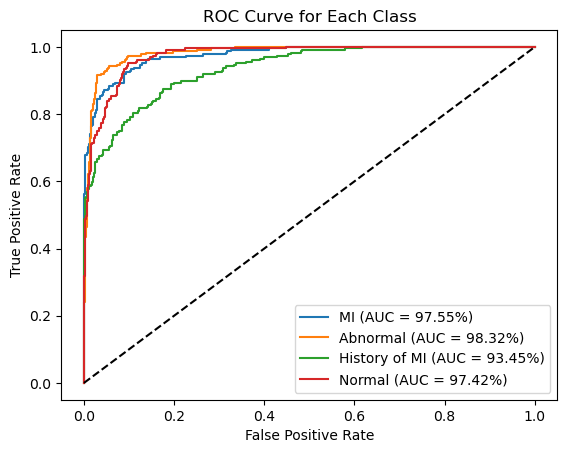

In [14]:
#binarizes labels for multi-class ROC curve
binarized_labels = label_binarize(actual_classes, classes=[0, 1, 2, 3])
n_classes = binarized_labels.shape[1]

#defines class labels
class_labels = ['MI', 'Abnormal', 'History of MI', 'Normal']

#computes ROC curve and ROC area for each class
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(binarized_labels[:, i], predictions[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_labels[i]} (AUC = {roc_auc*100:.2f}%)')

#plots the curves along with AUC scores
plt.plot([0, 1], [0, 1], 'k--')  #diagonal line for random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc='lower right')
plt.show()